<a href="https://colab.research.google.com/github/V5NEXT/GNN/blob/main/GNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 16.9 MB/s 
     |████████████████████████████████| 482 kB 52.4 MB/s 
     |████████████████████████████████| 462 kB 46.8 MB/s 
     |████████████████████████████████| 41 kB 559 kB/s 


In [3]:
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [4]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [7]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [8]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)



In [9]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Genetic_Algorithms,22
Probabilistic_Methods,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [10]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [11]:
generator = FullBatchNodeGenerator(G, method="gcn")
train_gen = generator.flow(train_subjects.index, train_targets)
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

Using GCN (local pooling) filters...


In [12]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [13]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [14]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [17]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.9579 - acc: 0.1214 - val_loss: 1.9192 - val_acc: 0.2800 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.9070 - acc: 0.3357 - val_loss: 1.8848 - val_acc: 0.3200 - 155ms/epoch - 155ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8598 - acc: 0.3500 - val_loss: 1.8334 - val_acc: 0.3180 - 149ms/epoch - 149ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7856 - acc: 0.3786 - val_loss: 1.7642 - val_acc: 0.3220 - 152ms/epoch - 152ms/step
Epoch 5/200
1/1 - 0s - loss: 1.7105 - acc: 0.3929 - val_loss: 1.6873 - val_acc: 0.3240 - 147ms/epoch - 147ms/step
Epoch 6/200
1/1 - 0s - loss: 1.6044 - acc: 0.3857 - val_loss: 1.6166 - val_acc: 0.3300 - 152ms/epoch - 152ms/step
Epoch 7/200
1/1 - 0s - loss: 1.5316 - acc: 0.4000 - val_loss: 1.5592 - val_acc: 0.3440 - 155ms/epoch - 155ms/step
Epoch 8/200
1/1 - 0s - loss: 1.4251 - acc: 0.4071 - val_loss: 1.4986 - val_acc: 0.4040 - 159ms/epoch - 159ms/step
Epoch 9/200
1/1 - 0s - loss: 1.3132 - acc: 0.4929 - val_loss: 1.4268 - val_acc: 0.5120 - 146ms

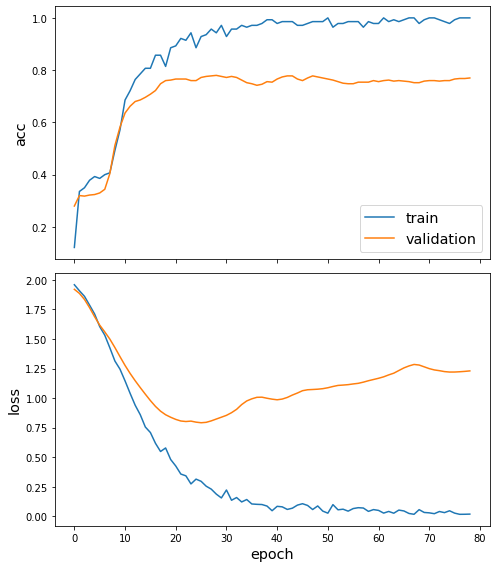

In [18]:
sg.utils.plot_history(history)

In [19]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [20]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 152ms/step - loss: 0.7515 - acc: 0.7834

Test Set Metrics:
	loss: 0.7515
	acc: 0.7834


In [21]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [22]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [23]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Case_Based,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory
